In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import fredapi as fa
from scipy import stats
import numpy as np
sns.set()

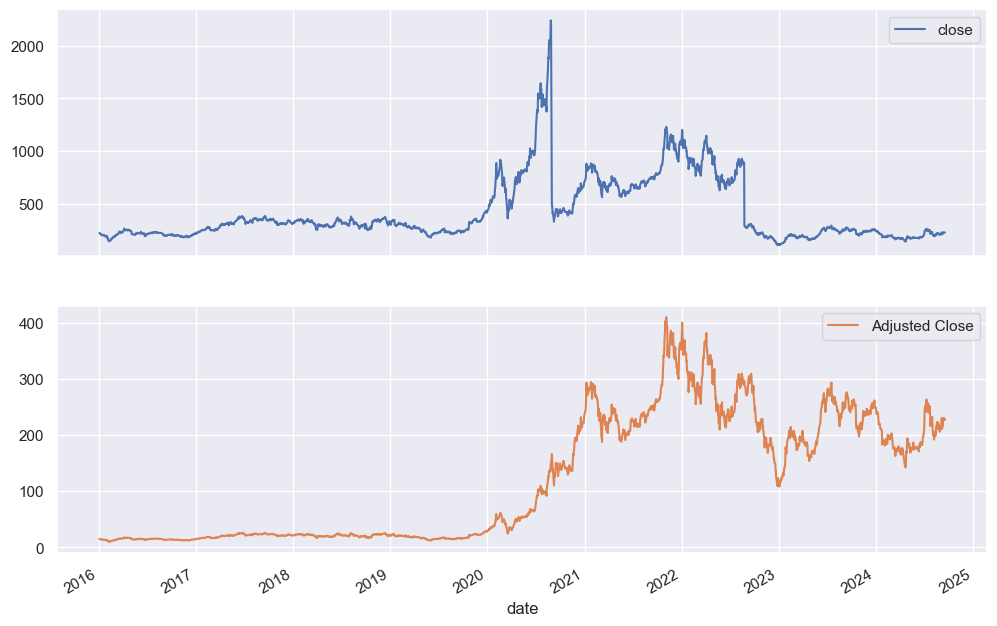

In [3]:
#你不能拿一只在 2020 拆过 5 次的股票跟没拆过的股票混在一起算收益，那等于你说“我家的冰箱是5个小冰箱拼起来的，所以家里变凉了。”不，你只是在骗人。


# 引入数据：从 GitHub 上读取 TSLA 历史价格
tsla = pd.read_csv("https://raw.githubusercontent.com/DonLeKouT/Just_files/refs/heads/main/TSLA_stock_price.csv")

# 设置日期为索引列（方便按时间过滤和处理）
tsla.set_index('date', inplace=True)

# 把字符串时间变成 pandas 能识别的时间格式
tsla.index = pd.to_datetime(tsla.index)

# 拆股信息：两个拆股事件
# 2020-08-31 拆5：1；2022-08-25 拆3：1
splits = {
    '2022-08-25' : 3,   # 每1股变成3股（价格 / 3）
    "2020-08-31" : 5    # 每1股变成5股（价格 / 5）
}

# 复制一份 close 列作为 Adjusted Close 初始值
tsla['Adjusted Close'] = tsla['close'].copy()

# ！   遍历每个拆股事件，调整拆股之前的价格（注意是"之前"）
for date, split in splits.items():
    # 拆股是在这天执行的，我们要往前一天调整价格
    date = pd.to_datetime(date) - pd.Timedelta(days=1)

    # ！ 所有早于该时间的价格都需要被“除以”拆股因子（例如 1变3 股价降为1/3）
    tsla.loc[:date, 'Adjusted Close'] = tsla.loc[:date, 'Adjusted Close'] / split

# 画图：展示 2016 年起的 close 和 adjusted close 走势
tsla[['close', 'Adjusted Close']].loc["2016":].plot(figsize=(12, 8), subplots = True)

# 显示图像
plt.show()


/Users/huayitang/PycharmProjects/WQU_Msc_notes/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


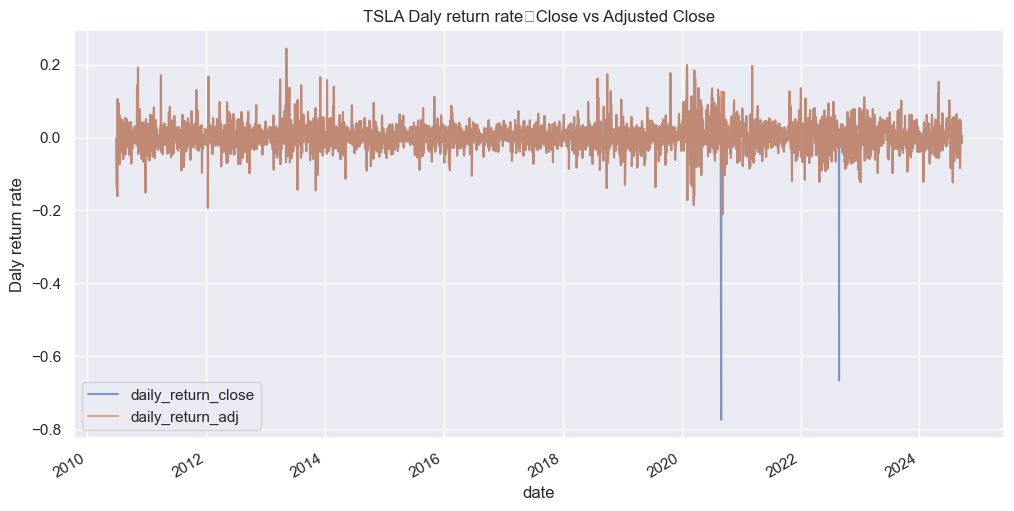

Daly return rate mean ： 0.00043737117886012196
Daly return max： 0.9005511882172224


In [4]:
'''
🧪 Exercise 2：计算 TSLA 每日收益率（close 和 adjusted-close）
✅ 目标：
比较用 原始收盘价 和 调整后收盘价 计算出来的日收益率，有没有区别。

Spoiler alert：如果只有拆股，没有分红，收益率几乎一模一样。你等等就看到了。

'''

# 计算日收益率（百分比形式）
tsla['daily_return_close'] = tsla['close'].pct_change()
tsla['daily_return_adj'] = tsla['Adjusted Close'].pct_change()

# 可视化收益率对比
tsla[['daily_return_close', 'daily_return_adj']].dropna().plot(figsize=(12,6), alpha=0.7)
plt.title("TSLA Daly return rate：Close vs Adjusted Close")
plt.ylabel("Daly return rate")
plt.xlabel("date")
plt.grid(True)
plt.show()

# 对比两者差值有多大
diff = (tsla['daily_return_close'] - tsla['daily_return_adj']).abs()
print("Daly return rate mean ：", diff.mean())
print("Daly return max：", diff.max())


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


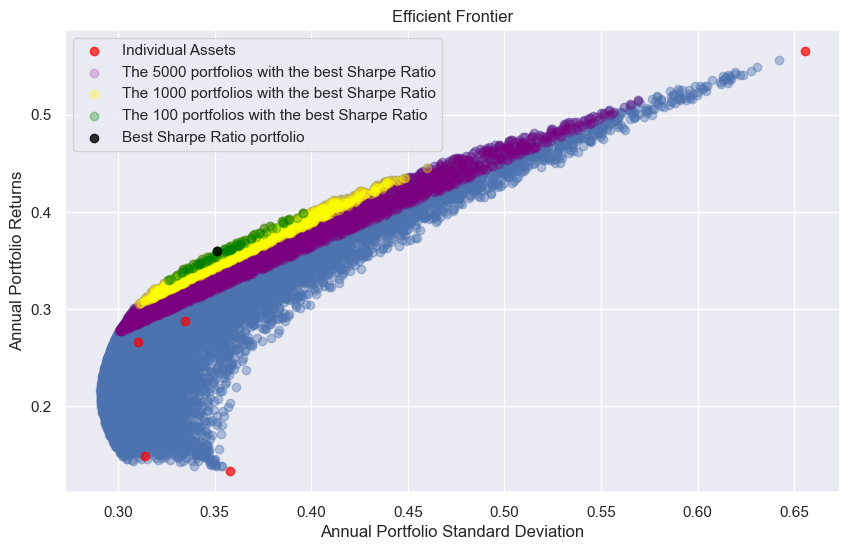

In [5]:
'''
3. Portfolio Sharpe Ratio and the Efficient Frontier
3. 投资组合夏普比率与有效前沿

我们在上一单元中已经提到了夏普比率的含义。现在我们将阐述夏普比率在投资组合管理中的重要性。为此，我们将假设第一课中的资产，




##########并展示夏普比率最高的投资组合相对于有效前沿的位置。

# 随机生成2万组投资组合权重（5只股票）
weights = np.random.dirichlet(np.ones(5)*0.7, 20000)

# 计算每个组合的三要素：
for w in weights:
  收益 = 股票平均收益 @ 权重       # 收益 = Σ(股票收益×权重)
  风险 = √(权重ᵀ × 协方差矩阵 × 权重) # 风险 = 组合波动率
  夏普 = (收益 - 无风险利率) / 风险
'''
assets = ['MSFT', 'AAPL', 'AMZN', 'TSLA', 'GOOGL']  # 定义投资组合中的资产（微软、苹果、亚马逊、特斯拉、谷歌）

# 下载这些资产的“调整后收盘价”数据（自动调整分红/拆股），从2018年到2023年
asset_prices = yf.download(assets, start='2018-01-01', end='2023-01-01', auto_adjust = False)['Adj Close']

# 把索引转换为纯日期，避免时间信息造成的混乱
asset_prices.index = pd.to_datetime(asset_prices.index.date)

# 下载无风险利率的数据（3个月期美债，符号是 ^IRX）
risk_free = yf.download('^IRX', start='2018-01-01', end='2023-01-01', auto_adjust = False)['Adj Close']
risk_free.index = pd.to_datetime(risk_free.index.date)

# 计算每日收益率（百分比收益率），用的是 pct_change，之后删除第一行的缺失值
r = asset_prices.pct_change().dropna()

# 使用 Dirichlet 分布生成 20000 组投资组合权重（5个资产），每组权重之和为 1
weights = np.random.dirichlet(np.ones(5)*0.7, size = 20000)

# 检查所有权重组合是否都满足“权重和为 1”的条件
assert np.isclose(np.sum(weights, axis = 1), 1).all()

# 存放每组权重对应的收益、波动率、夏普比
eff_front_dict = {}

# 年化协方差矩阵（因为我们用的是日收益率）
cov_matrix_ret = r.cov() * 252

# 每只资产的年化预期收益
expected_returns = r.mean() * 252

# 获取无风险利率（已经是年化的），转换为小数
risk_free_rate = risk_free['^IRX'].mean() / 100

# 遍历每组权重，计算对应的组合表现
for w in weights:
    port_ret = expected_returns @ w.T  # 投资组合的预期年化收益
    port_std = np.sqrt(w.T @ cov_matrix_ret @ w)  # 投资组合的年化波动率
    sharpe_ratio = (port_ret - risk_free_rate) / port_std  # 计算夏普比
    eff_front_dict[str(list(w))] = [port_ret, port_std, sharpe_ratio]  # 保存结果

# 整理成 DataFrame，行是不同组合，列是收益、风险、夏普比
eff_frontier_dataframe = pd.DataFrame(
    eff_front_dict,
    index = ['Returns', 'Standard Deviation', 'Sharpe Ratio']
).T

# 按照夏普比从高到低排序，找出最优组合
highest_sharpe_ratio = eff_frontier_dataframe.sort_values(by = 'Sharpe Ratio', ascending = False)

# 画图开始！—— 散点图展示所有组合的收益 vs 风险
plt.figure(figsize = (10,6))
plt.scatter(
    x = eff_frontier_dataframe['Standard Deviation'],
    y = eff_frontier_dataframe['Returns'],
    alpha = 0.4
)

# 用红点标出单个资产的位置（不是组合）
plt.scatter(
    x = r.std() * np.sqrt(252),
    y = expected_returns,
    color = 'red',
    label = "Individual Assets",
    alpha = 0.7
)

# 分层标记最优秀的组合们
plt.scatter(
    x = highest_sharpe_ratio[:5000]['Standard Deviation'],
    y = highest_sharpe_ratio[:5000]['Returns'],
    color = 'purple',
    alpha = 0.2,
    label = "The 5000 portfolios with the best Sharpe Ratio"
)
plt.scatter(
    x = highest_sharpe_ratio[:1000]['Standard Deviation'],
    y = highest_sharpe_ratio[:1000]['Returns'],
    color = 'yellow',
    alpha = 0.3,
    label = "The 1000 portfolios with the best Sharpe Ratio"
)
plt.scatter(
    x = highest_sharpe_ratio[:100]['Standard Deviation'],
    y = highest_sharpe_ratio[:100]['Returns'],
    color = 'green',
    alpha = 0.3,
    label = "The 100 portfolios with the best Sharpe Ratio"
)

# 标记出最优组合（夏普比最高那个）
plt.scatter(
    x = highest_sharpe_ratio.iloc[0,:]['Standard Deviation'],
    y = highest_sharpe_ratio.iloc[0,:]['Returns'],
    color = 'black',
    alpha = 0.8,
    label = "Best Sharpe Ratio portfolio"
)

# 图表格式设置
plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.show()



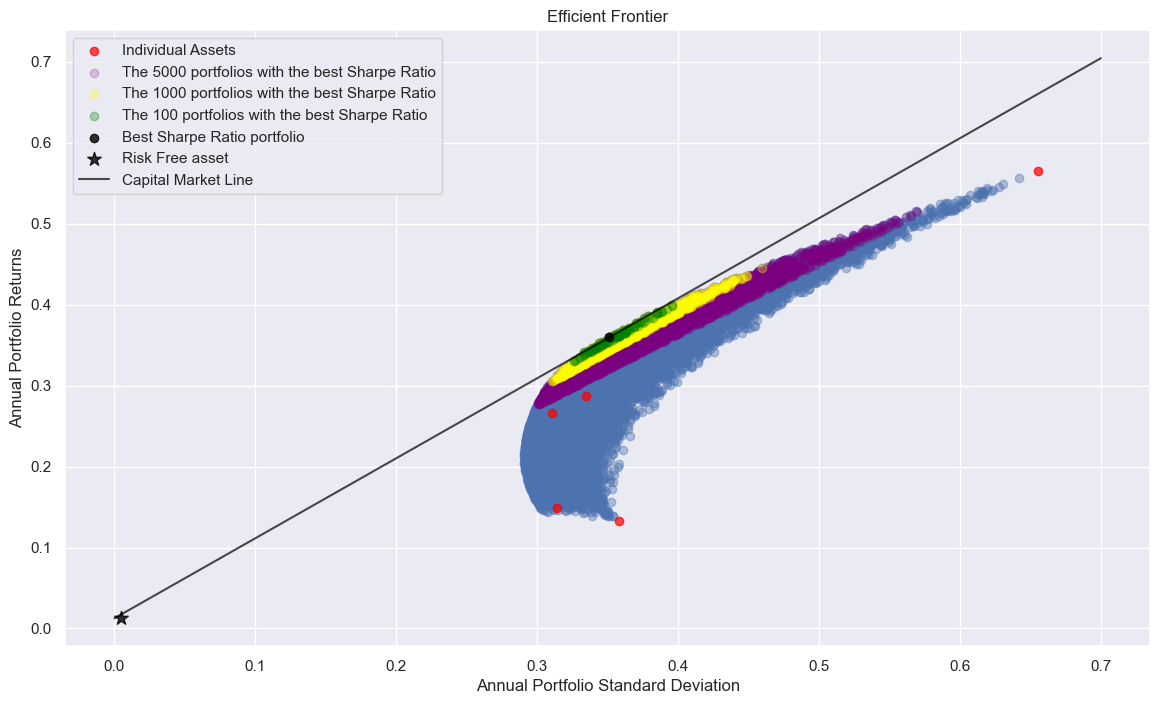

In [6]:
'''本段代码的目的是绘制“资本市场线（Capital Market Line，CML）”。
CML 是投资组合理论中最重要的一条线，它展示了：
1. 投资人可以通过把资金分配到“无风险资产 + 最优风险组合”之间，构建出更好的投资组合。
2. 它的斜率 = Sharpe Ratio 最优的投资组合（也叫切线组合）。
3. CML 上的每一点都是某种“你买了部分无风险资产 + 某个比例的最优风险资产”的组合。

知识点涵盖：
- 夏普比率（Sharpe Ratio）衡量风险调整后收益的能力。
- 投资组合收益和波动（均值 + 协方差矩阵）。
- 无风险资产的引入如何改变投资边界。
- CML 是有效前沿线中最优的那条直线。

图中展示：
- 所有可能组合的点（蓝色）
- 单个资产的风险和收益（红色）
- 各种 Sharpe 比较高的组合（紫、黄、绿点）
- 无风险资产（黑色星号）
- CML（黑线），起于无风险资产，切于最优 Sharpe 投组合点

一句话总结：
**这段代码帮你看懂了“合理投资”的上限长什么样，CML 是你配置资产的神之参考线。**
'''

sigmas = np.linspace(0,0.7, 100)
CML = risk_free_rate + highest_sharpe_ratio['Sharpe Ratio'].iloc[0] * sigmas # This is the Capital Market Line

# Plot the portfolio returns vs portfolio variance
plt.figure(figsize = (14,8))
plt.scatter(x = eff_frontier_dataframe['Standard Deviation'], y = eff_frontier_dataframe['Returns'], alpha = 0.4)
plt.scatter(x = r.std() * np.sqrt(252), y = expected_returns, color = 'red', label = "Individual Assets", alpha = 0.7)
plt.scatter(x = highest_sharpe_ratio[:5000]['Standard Deviation'], y = highest_sharpe_ratio[:5000]['Returns'], color = 'purple', alpha = 0.2, label = "The 5000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:1000]['Standard Deviation'], y = highest_sharpe_ratio[:1000]['Returns'], color = 'yellow', alpha = 0.3, label = "The 1000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:100]['Standard Deviation'], y = highest_sharpe_ratio[:100]['Returns'], color = 'green', alpha = 0.3, label = "The 100 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio.iloc[0,:]['Standard Deviation'], y = highest_sharpe_ratio.iloc[0,:]['Returns'], color = 'black', alpha = 0.8, label = "Best Sharpe Ratio portfolio" )
plt.scatter(x = (risk_free / 252).std(), y = risk_free_rate, color = 'black', alpha = 0.8, marker = '*', label = "Risk Free asset", s = 105)
plt.plot(sigmas, CML, color = 'black', label = "Capital Market Line", alpha = 0.7)


plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


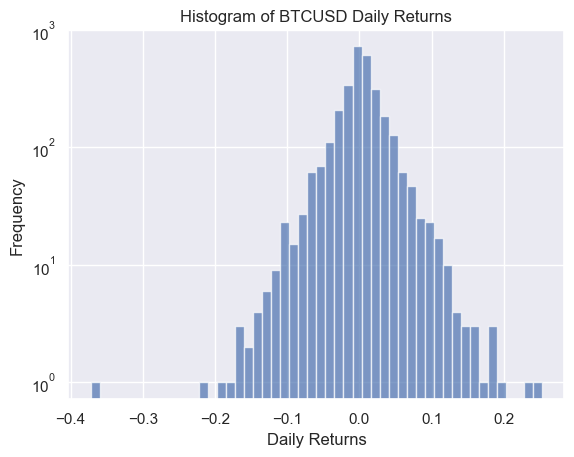

The Historical VaR with confidence 0.9 is -3.717% 

The Historical VaR with confidence 0.95 is -6.0% 

The Historical VaR with confidence 0.99 is -10.57% 



In [18]:
'''
6.1 Implementing Value at Risk (VaR) - Historical Method
本段代码用于绘制比特币（BTC-USD）日收益率的直方图（Figure 1）。

目的：
- 观察比特币每日收益率（percent change）的分布形态。
- 分析比特币是否符合正态分布，识别极端波动的频率。

知识点涵盖：
1. **收益率计算**：通过 `pct_change()` 获取每天的收益变化百分比。
2. **分布特征**：直方图揭示了比特币收益的偏度（skewness）、峰度（kurtosis）等非对称特性。
3. **对数坐标（log=True）**：y 轴取对数，用于更清晰地观察极端波动频次（尤其是尾部行为）。
4. **金融数据中的极端风险**：通过直方图可以直观看出“肥尾”现象，提醒你 BTC 并不是个“温和的小宠物”。

一句话总结：
**这段代码画出来的图，是你被比特币割韭菜的概率地图。**

'''

# Figure 1
btcusd = yf.download("BTC-USD", start="2014-09-18", end="2022-12-31", auto_adjust = False)['Adj Close']
btcusd_returns = btcusd.pct_change().dropna()

plt.hist(x = btcusd_returns, bins=50, log = True, alpha = 0.7)


plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Histogram of BTCUSD Daily Returns')
plt.show()
def getHistoricalVar(returns, confidenceLevel):
    var = np.quantile(returns, 1 - confidenceLevel)
    print(
        f"The Historical VaR with confidence {confidenceLevel} is {round(100 * var, 3)}% \n"
    )

getHistoricalVar(btcusd_returns, 0.90)
getHistoricalVar(btcusd_returns, 0.95)
getHistoricalVar(btcusd_returns, 0.99)

In [9]:
'''
本段代码的目的是使用历史数据计算比特币（BTC）每日收益的“条件风险价值”（Conditional Value at Risk，简称 CVaR 或 Expected Shortfall）。

🔍 CVaR 是什么？
- CVaR 表示：在已经发生超过 VaR 的极端亏损时，这些极端情况的平均亏损有多严重。
- 举个例子：VaR 告诉你 “95% 的时候最多亏 6%”，
  而 CVaR 告诉你 “那剩下最惨的 5% 里面，平均亏多少”——更痛，但也更真实。

🧮 历史 CVaR 的计算方法（非参数，不假设分布）：
1. 计算出 VaR（例如 95% 置信水平）；
2. 找出所有比 VaR 更惨的收益；
3. 对这些极端亏损求平均，得出 CVaR。

🧠 知识点涉及：
- 风险度量（Risk Metrics）
- Value at Risk (VaR)
- Conditional Value at Risk (CVaR)
- 金融数据分布尾部的期望
- 非参数方法（历史模拟）

⚠️ 为什么重要？
CVaR 是更保守、也更实际的风险评估工具。特别是在像比特币这种每天都像在坐过山车的资产里，VaR 往往太乐观，CVaR 才告诉你真正会多疼。
'''
def getHistoricalCVar(returns, confidenceLevel):
    var = np.quantile(returns, 1 - confidenceLevel)
    cvar = returns[returns <= var].mean()
    print(
        f"With {confidenceLevel} percent confidence VaR, our Expected Shortfall is {round(100 * cvar, 3)} using historical VaR \n"
    )

getHistoricalCVar(btcusd_returns, 0.90)
getHistoricalCVar(btcusd_returns, 0.95)
getHistoricalCVar(btcusd_returns, 0.99)

With 0.9 percent confidence VaR, our Expected Shortfall is Ticker
BTC-USD   -6.893
dtype: float64 using historical VaR 

With 0.95 percent confidence VaR, our Expected Shortfall is Ticker
BTC-USD   -9.017
dtype: float64 using historical VaR 

With 0.99 percent confidence VaR, our Expected Shortfall is Ticker
BTC-USD   -14.285
dtype: float64 using historical VaR 



In [10]:
'''
本段代码目的是通过两种参数方法计算比特币（BTC）每日收益的 Value at Risk（VaR）：

1. **正态分布法（Normal VaR）**
2. **t 分布法（Student's t-distribution VaR）**

🎯 为什么要搞这俩？
- 正态分布方法（Parametric VaR）速度快，适用于“看上去不那么像要爆炸的资产”。
- 但现实很残酷，金融市场的数据往往 **偏态** + **厚尾**（kurtosis 高），特别是像 BTC 这种——你昨天还在天堂，今天可能在火葬场。
- 所以我们还得引入更贴合极端事件的 **t 分布方法**（尾部更肥），用来估算那些“真的爆了”的情形。

🧠 涉及知识点：
- 概率分布的尾部行为（fat tails）
- 正态分布假设 vs. t 分布现实主义
- VaR（Value at Risk）风险指标
- 参数方法（Parametric Approach）
- scipy.stats 模块的使用（`norm.ppf` 和 `t.ppf`）

🧮 VaR 是怎么计算的？
- VaR = 给定置信度下，未来可能亏损的最大值（比如 95% 置信度，对应最惨的 5% 情况）
- `norm.ppf(0.05)` 给你一个标准正态分布下 5% 位置的收益
- `t.ppf(0.05, dof)` 则更能反映极端情况的下尾风险（尤其当 dof 较小时）

⚠️ 总结：
- **正态分布 VaR：** 简单粗暴但可能低估尾部风险；
- **t 分布 VaR：** 更贴近现实，但参数选择（自由度 dof）需要谨慎；
- **历史 VaR：** 最贴近实际，但依赖数据样本是否“见过地狱”。

最终你会发现：搞金融不是为了预测未来，而是为了承认我们完全无法预测未来。
'''
mean = btcusd_returns.mean()
std = btcusd_returns.std()

var_90 = stats.norm.ppf(0.1, mean, std)[0]
var_95 = stats.norm.ppf(0.05, mean, std)[0]
var_99 = stats.norm.ppf(0.01, mean, std)[0]

print(f"The parametric VaR assuming a normal distribution with a 90% confidence interval, is {round(100 * var_90, 3)} \n")
print(f"The parametric VaR assuming a normal distribution with a 95% confidence interval, is {round(100 * var_95, 3)} \n")
print(f"The parametric VaR assuming a normal distribution with a 99% confidence interval, is {round(100 * var_99, 3)} \n")

The parametric VaR assuming a normal distribution with a 90% confidence interval, is -4.716 

The parametric VaR assuming a normal distribution with a 95% confidence interval, is -6.108 

The parametric VaR assuming a normal distribution with a 99% confidence interval, is -8.72 



In [11]:
# degrees of freedom
'''
在对厚尾数据进行建模时，学生 t 分布通常用作正态分布的替代方法。自由度参数控制尾部的厚重程度。随着自由度的增加，t 分布趋近于正态分布。自由度 (dof) 越小，尾部越厚，表明出现极值的概率越高。
'''
def getTVar(returns, dof, confidenceLevel):
    mean = returns.mean()
    std = returns.std()
    var = np.sqrt((dof - 2) / dof) * stats.t.ppf(1 - confidenceLevel, dof) * std + mean
    return (100 * var).round(3)

print(f"The parametric VaR using t-distribution with a confidence interval 0.9, is {getTVar(btcusd_returns, 5, 0.9)}% \n")
print(f"The parametric VaR using t-distribution with a confidence interval 0.95, is {getTVar(btcusd_returns, 5, 0.95)}% \n")
print(f"The parametric VaR using t-distribution with a confidence interval 0.99, is {getTVar(btcusd_returns, 5, 0.99)}% \n")


The parametric VaR using t-distribution with a confidence interval 0.9, is Ticker
BTC-USD   -4.186
dtype: float64% 

The parametric VaR using t-distribution with a confidence interval 0.95, is Ticker
BTC-USD   -5.786
dtype: float64% 

The parametric VaR using t-distribution with a confidence interval 0.99, is Ticker
BTC-USD   -9.793
dtype: float64% 



在置信度 95.0% 下的一天VaR是: -$3,253.02


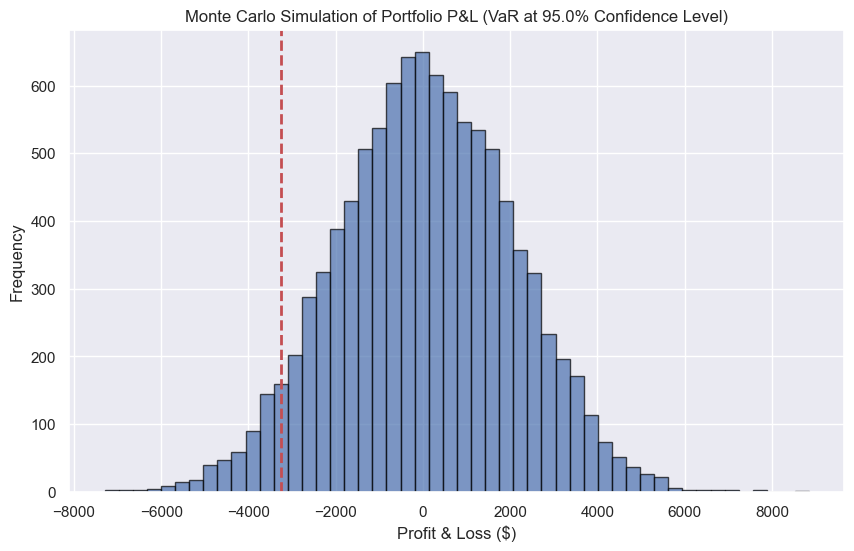

In [21]:
'''
我们讨论了如何使用金融系列的历史数据来计算风险价值 (VaR)。但是，如果我们的数据不完整或不足，该怎么办？在这种情况下，我们可以假设一个生成数据的分布，并使用这些分布假设进行模拟。这种方法称为蒙特卡洛 VaR。

蒙特卡洛风险价值 (VaR) 包含一系列模拟，其中每个收益流都表示为一个随机变量。该变量可以取自任何概率分布，这很棒，因为这意味着它不一定假设正态分布。在选择使用哪种分布方面具有很大的灵活性。然后，所有变量都经过加权并进行模拟，以查看每次运行结束时投资组合的总价值。这些模拟收益随后按从低到高的顺序排序，我们可以轻松地使用与历史方法类似的计算方法来查看风险价值，只是这次我们使用的是模拟收益而不是历史收益。例如，如果您运行了一系列 1,000 次模拟，则需要查看第 50 个最低值来确定 95% 置信区间的风险价值 (VaR)。

'''

# 参数设置
initial_investment = 100000  # 初始投入的金额（比如投资10万）
mean_return = 0.0005  # 预期的每日收益率是 0.05%
volatility = 0.02  # 每日波动率是 2%，不是年化的
days = 1  # 预测的是未来1天的情况
num_simulations = 10000  # 模拟一万个可能的情况（蒙特卡洛模拟次数）
confidence_level = 0.95  # VaR的置信水平是95%，也就是说只考虑最坏的5%

# 用正态分布来随机生成每日收益（基于设定的均值和波动率）
np.random.seed(2024)  # 设置种子，为了每次运行结果一样，方便对比
random_returns = np.random.normal(loc=mean_return * days, scale=volatility * np.sqrt(days), size=num_simulations)

# 计算模拟后每种情况下的投资组合价值
portfolio_end_values = initial_investment * (1 + random_returns)

# 计算每种情况下的盈亏（模拟的收益减去本金）
portfolio_pnl = portfolio_end_values - initial_investment

# 计算在指定置信水平下的VaR（也就是最坏的5%里最大亏多少钱）
VaR = np.percentile(portfolio_pnl, (1 - confidence_level) * 100)

# 打印VaR结果
print(f"在置信度 {confidence_level * 100}% 下的一天VaR是: -${abs(VaR):,.2f}")

#Plot the distribution of portfolio P&L
plt.figure(figsize=(10, 6))
plt.hist(portfolio_pnl, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=VaR, color='r', linestyle='dashed', linewidth=2)
plt.title(f"Monte Carlo Simulation of Portfolio P&L (VaR at {confidence_level * 100}% Confidence Level)")
plt.xlabel('Profit & Loss ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
